<a href="https://colab.research.google.com/github/twinkle-fist/web/blob/master/senator_pca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PCA and senate voting data


In this problem, we are given the $n \times d$ data matrix $X$ with entries in $\{-1,0,1\}$, where each row corresponds to a senator and each column to a bill. We first import this data, print some relevant values, and normalize it as necessary to ready it for further computation.

To run this code, you'll need a number of standard Python libraries, all of which are installable via $\texttt{pip}$ or $\texttt{conda}$. We highly recommend using a [virtual environment](https://realpython.com/python-virtual-environments-a-primer/), for this class and in general.

Lastly, ensure that all data files (`senator_pca_data_matrix.csv` and `senator_pca_politician_labels.txt`) are located in the same folder as the notebook.

### Places you will need to modify this code are enclosed in a $\texttt{\#TODO}$ block. You should not need to modify code outside these blocks to complete the problems. Questions that you are expected to answer in text are marked in <font color='red'>red</font>. For solution files, solutions will be presented in <font color='blue'>blue</font>.

In [ ]:
# import the necessary packages for data manipulation, computation and PCA
import pandas as pd
import numpy as np
import scipy as sp
from numpy import linalg as LA
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
%matplotlib inline

np.random.seed(7)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# import the data matrix
senator_df =  pd.read_csv('/content/drive/My Drive/hw04_jupyter_prob/senator_pca/senator_pca_data_matrix.csv')
affiliation_file = open('/content/drive/My Drive/hw04_jupyter_prob/senator_pca/senator_pca_politician_labels.txt', 'r')
affiliations = [line.split('\n')[0].split(' ')[1] for line in affiliation_file.readlines()]
X = np.array(senator_df.values[:, 3:].T, dtype='float64') # transpose to get senators as rows
print('X.shape: ', X.shape)
n = X.shape[0] # number of senators
d = X.shape[1] # number of bills

# this is just used for plotting, feel free to ignore
assert set(affiliations) == {"Red", "Blue", "Yellow"}
# assign a marker and hatch to each affiliation
markers = [("Red", "o", "/"), ("Blue", "^", "-"), ("Yellow", "D", "+")]

X.shape:  (100, 542)


We observe that the number of rows, $n$, is the number of senators and is equal to 100. The number of columns, $d$, is the number of bills and is equal to 542.

In [ ]:
# print an example row of the data matrix
typical_row = X[0]
print(typical_row.shape)
print(typical_row)

(542,)
[ 1.  1.  1. -1. -1.  1.  1.  1.  1. -1.  1. -1. -1.  1.  1. -1.  1.  1.
  1.  1.  1. -1.  1.  1.  1. -1.  1. -1.  1.  1.  1.  1.  1. -1.  1. -1.
 -1. -1. -1.  1.  1. -1. -1. -1. -1.  1.  1.  1. -1.  1.  1. -1.  1.  1.
 -1.  1.  1.  1.  1. -1.  1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1. -1.  0. -1.  1.  1.  1. -1. -1.  1.  1. -1. -1.  1.  1.  1. -1.
  1. -1.  1. -1.  1.  1. -1. -1. -1.  1.  1.  1. -1. -1. -1. -1. -1. -1.
  1. -1.  1.  1. -1. -1. -1.  1. -1.  1. -1.  1.  0.  0.  1.  1. -1.  1.
  1. -1.  1.  1. -1.  1. -1. -1.  1.  1.  1.  1.  0. -1. -1.  1.  1. -1.
  1.  1.  1.  1.  1.  0.  1.  0.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.
 -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1. -1. -1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1. -1.
  1.  1.  0.  1.  0. -1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.

A row of $X$ consists of 542 entries -1 (senator voted against), 1 (senator voted for), or 0 (senator abstained), one for each bill.

In [ ]:
# print an example column of the data matrix
typical_column = X[:,0]
print(typical_column.shape)
print(typical_column)

(100,)
[ 1.  1.  1.  1.  1.  1.  1. -1.  1. -1.  1. -1.  1. -1. -1. -1.  1.  1.
 -1.  1.  1. -1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1. -1.  1.  1.  1.
 -1. -1. -1. -1.  1. -1. -1.  1.  1. -1. -1. -1. -1. -1.  1.  1. -1. -1.
  1.  1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1. -1. -1. -1.  1. -1. -1.
  1. -1. -1.  1.  1.  1. -1. -1. -1.  1.  1. -1.  1. -1.  1.  1.  1. -1.
 -1. -1. -1. -1.  1.  1.  1. -1. -1. -1.]


A column of $X$ consists of 100 entries in \{-1, 0, 1\}, one for each senator that voted on the bill.

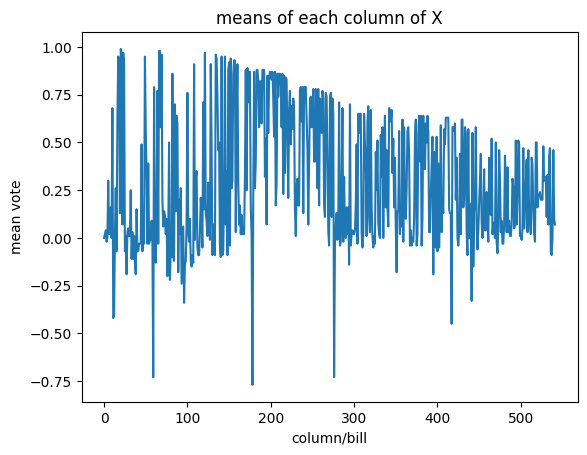

In [ ]:
# compute the mean vote on each bill
X_mean = np.mean(X, axis = 0)
plt.plot(X_mean)
plt.title('means of each column of X')
plt.xlabel('column/bill')
plt.ylabel('mean vote')
plt.show()

We observe that the mean of the columns is not zero, so we center the data by subtracting the mean of each bill's vote from its respective column.

In [ ]:
# center the data matrix
X_original = X.copy() # save a copy for part (d) and (e)
X = X - np.mean(X, axis = 0)

## a) Maximizing $\sigma^{2}(f(X,\vec{a}))$

In this problem, you are asked to find a unit-norm vector $\vec{a} \in \mathbb{R}^{d}$ maximizing the empirical variance $\sigma^{2}(f(X,\vec{a}))$.

We first provide a function to calculate the scores, $f(X,\vec{a})$.

In [ ]:
# define score function
def f(X, a):
    return X @ a

Before we calculate the $\vec{a}$ that maximizes variance, let's observe what the scalar projections on a random direction $\vec{a}$ look like.

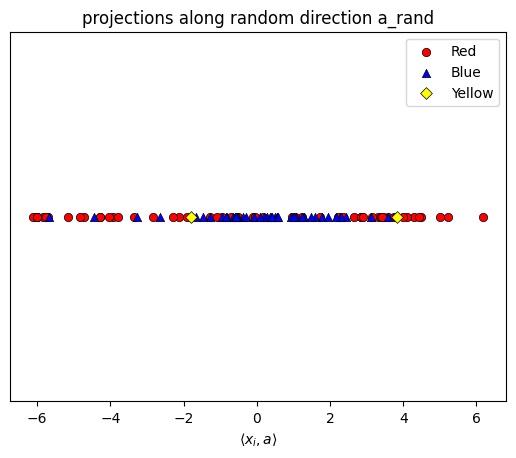

variance along random direction a_rand:  9.26745439089334


In [ ]:
# generate a random direction and normalize the vector
a_rand = np.random.rand(d)
a_rand = a_rand/np.linalg.norm(a_rand)

# compute associated scores along a_rand
scores_rand = f(X, a_rand)

# visualize the scores along a_rand, coloring them by party affiliation
for aff, marker, _ in markers:
    plt.scatter(
        scores_rand[np.array(affiliations) == aff],
        np.zeros_like(scores_rand[np.array(affiliations) == aff]),
        c=aff, marker=marker, edgecolors="black", linewidth=0.5, label=aff
    )
plt.legend()
plt.title('projections along random direction a_rand')
plt.xlabel('$\\langle x_i, a\\rangle$')
cur_axes = plt.gca()
cur_axes.axes.get_yaxis().set_visible(False)
plt.show()

print('variance along random direction a_rand: ', scores_rand.var())

Note here that projecting along the random vector $\texttt{a\_rand}$ does not explain much variance at all — data points are clustered together and intermixed across parties. It is clear that this direction does not give us any information about the senators' affiliations.

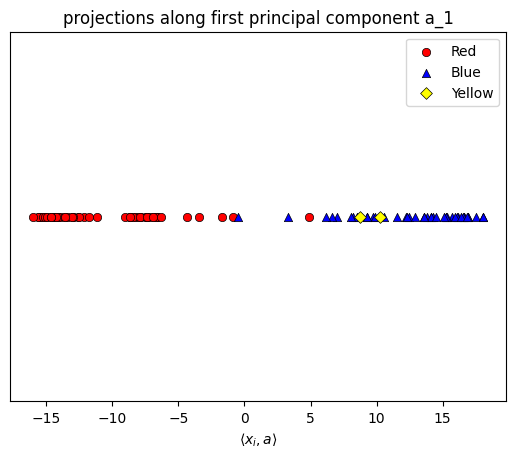

variance along first principal component:  149.7489650762074


In [ ]:
################################################################################
### TODO: Calculate a_1, the first principal component of X.
# Hint: The PCA package imported from sklearn.decomposition will be useful here,
# in particular the function pca.fit(). What should the dimensions of a_1 be?

pca = PCA(n_components=1)
pca.fit(X)
a_1 = pca.components_[0]  # An array with shape (n_features)

### end TODO
################################################################################

a_1 = a_1/np.linalg.norm(a_1)
# compute and visualize the scores along a_1
scores_a_1 = f(X, a_1)

for aff, marker, _ in markers:
    plt.scatter(
        scores_a_1[np.array(affiliations) == aff],
        np.zeros_like(scores_a_1[np.array(affiliations) == aff]),
        c=aff, marker=marker, edgecolors="black", linewidth=0.5, label=aff
    )
plt.legend()
plt.title('projections along first principal component a_1')
plt.xlabel('$\\langle x_i, a \\rangle$')
cur_axes = plt.gca()
cur_axes.axes.get_yaxis().set_visible(False)
plt.show()

print('variance along first principal component: ', scores_a_1.var())

If you computed $\texttt{a\_1}$ correctly, you should observe that the variance is much higher than the $\texttt{a\_rand}$ projection, and that blue and red dots are now spread in two clusters. This makes sense: the first principal component is the direction along which data varies most, and that is often along party lines. You just found a mathematical model for partisanship!

## b) Comparison to party averages

We observed above that the direction of maximum variance appears to be determined by party alignment; we now want to quantify how true that is by computing variance along vectors that describe the average position of each party. Specifically, we will compute variance along the following two vectors:

- $\texttt{a\_mean\_red}$: unit vector along the mean of rows of $\texttt{X}$ corresponding to ‘Red’ senators
- $\texttt{a\_mean\_blue}$: unit vector along the mean of rows of $\texttt{X}$ corresponding to ‘Blue’ senators

#### Fill in the code as indicated below to calculate these values and compute their relationships to $\texttt{a\_1}$ and each other, then answer the interpretation question that follows.

100
['Red', 'Blue', 'Blue', 'Blue', 'Blue', 'Blue', 'Blue', 'Red', 'Blue', 'Red', 'Blue', 'Red', 'Blue', 'Red', 'Red', 'Red', 'Blue', 'Blue', 'Red', 'Blue', 'Blue', 'Blue', 'Blue', 'Red', 'Blue', 'Blue', 'Red', 'Red', 'Red', 'Blue', 'Blue', 'Blue', 'Red', 'Red', 'Yellow', 'Blue', 'Red', 'Red', 'Red', 'Red', 'Blue', 'Red', 'Red', 'Blue', 'Blue', 'Red', 'Red', 'Red', 'Red', 'Red', 'Blue', 'Blue', 'Red', 'Red', 'Blue', 'Blue', 'Red', 'Red', 'Red', 'Red', 'Red', 'Blue', 'Yellow', 'Blue', 'Blue', 'Blue', 'Red', 'Red', 'Red', 'Red', 'Red', 'Red', 'Red', 'Red', 'Red', 'Blue', 'Blue', 'Blue', 'Red', 'Red', 'Red', 'Blue', 'Red', 'Red', 'Blue', 'Red', 'Blue', 'Blue', 'Blue', 'Red', 'Red', 'Red', 'Red', 'Red', 'Blue', 'Blue', 'Blue', 'Red', 'Red', 'Red']


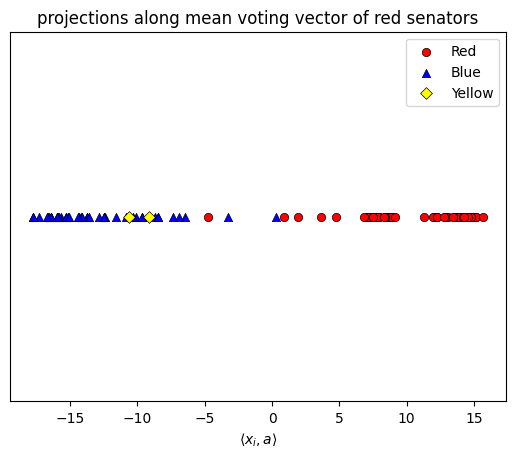

variance along mean voting vector of red senators:  148.80699963205717


In [ ]:
################################################################################
### TODO: Calculate mu_red, the array of dimension (542, ) whose values
### are the mean across rows of X corresponding to 'Red' senators only.
# Hint: Print out the 'affiliations' variable and observe its contents.
# print(len(affiliations))
# print(affiliations)
print(len(affiliations))
print(affiliations)
red_senators_indices = [i for i, aff in enumerate(affiliations) if aff == 'Red']
mu_red = np.mean(X[red_senators_indices, :], axis=0)
a_mean_red = mu_red / np.linalg.norm(mu_red)
scores_mean_red = f(X, a_mean_red)
### end TODO
################################################################################

# normalize the vector to generate unit a_mean_red
a_mean_red = mu_red/np.linalg.norm(mu_red)

# compute and visualize the scores along a_mean_red
scores_mean_red = f(X, a_mean_red)

for aff, marker, _ in markers:
    plt.scatter(
        scores_mean_red[np.array(affiliations) == aff],
        np.zeros_like(scores_mean_red[np.array(affiliations) == aff]),
        c=aff, marker=marker, edgecolors="black", linewidth=0.5, label=aff
    )
plt.legend()
plt.title('projections along mean voting vector of red senators')
plt.xlabel('$\\langle x_i, a \\rangle$')
cur_axes = plt.gca()
cur_axes.axes.get_yaxis().set_visible(False)
plt.show()

print('variance along mean voting vector of red senators: ', scores_mean_red.var())

100
['Red', 'Blue', 'Blue', 'Blue', 'Blue', 'Blue', 'Blue', 'Red', 'Blue', 'Red', 'Blue', 'Red', 'Blue', 'Red', 'Red', 'Red', 'Blue', 'Blue', 'Red', 'Blue', 'Blue', 'Blue', 'Blue', 'Red', 'Blue', 'Blue', 'Red', 'Red', 'Red', 'Blue', 'Blue', 'Blue', 'Red', 'Red', 'Yellow', 'Blue', 'Red', 'Red', 'Red', 'Red', 'Blue', 'Red', 'Red', 'Blue', 'Blue', 'Red', 'Red', 'Red', 'Red', 'Red', 'Blue', 'Blue', 'Red', 'Red', 'Blue', 'Blue', 'Red', 'Red', 'Red', 'Red', 'Red', 'Blue', 'Yellow', 'Blue', 'Blue', 'Blue', 'Red', 'Red', 'Red', 'Red', 'Red', 'Red', 'Red', 'Red', 'Red', 'Blue', 'Blue', 'Blue', 'Red', 'Red', 'Red', 'Blue', 'Red', 'Red', 'Blue', 'Red', 'Blue', 'Blue', 'Blue', 'Red', 'Red', 'Red', 'Red', 'Red', 'Blue', 'Blue', 'Blue', 'Red', 'Red', 'Red']


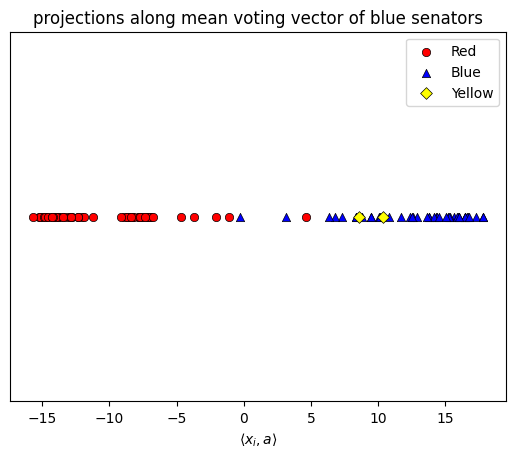

variance along mean voting vector of blue senators:  148.9088414400461


In [ ]:
################################################################################
### TODO: Calculate mu_blue, the array of dimension (542, ) whose values
### are the mean across rows of X corresponding to 'RBlue' senators only.
# Hint: Print out the 'affiliations' variable and observe its contents.
# print(len(affiliations))
# print(affiliations)
print(len(affiliations))
print(affiliations)
blue_senators_indices = [i for i, aff in enumerate(affiliations) if aff == 'Blue']
mu_blue = np.mean(X[blue_senators_indices, :], axis=0)
a_mean_blue = mu_blue / np.linalg.norm(mu_blue)
scores_mean_blue = f(X, a_mean_blue)
### end TODO
################################################################################

# normalize the vector to generate unit a_mean_blue
a_mean_blue = mu_blue/np.linalg.norm(mu_blue)

# compute and visualize the scores along a_mean_blue
scores_mean_blue = f(X, a_mean_blue)

for aff, marker, _ in markers:
    plt.scatter(
        scores_mean_blue[np.array(affiliations) == aff],
        np.zeros_like(scores_mean_blue[np.array(affiliations) == aff]),
        c=aff, marker=marker, edgecolors="black", linewidth=0.5, label=aff
    )
plt.legend()
plt.title('projections along mean voting vector of blue senators')
plt.xlabel('$\\langle x_i, a \\rangle$')
cur_axes = plt.gca()
cur_axes.axes.get_yaxis().set_visible(False)
plt.show()

print('variance along mean voting vector of blue senators: ', scores_mean_blue.var())


In [ ]:
# compute dot product of and angle between a_mean_red and a_mean_blue:
dot_product_blue_red = a_mean_blue.T @ a_mean_red
angle_blue_red = np.arccos(dot_product_blue_red) * 180/np.pi

print('dot product of a_mean_blue and a_mean_red: ', dot_product_blue_red)
print('angle between a_mean_blue and a_mean_red (degrees): ', angle_blue_red)


dot product of a_mean_blue and a_mean_red:  -0.9992350984093117
angle between a_mean_blue and a_mean_red (degrees):  177.75886458298191


### <font color='red'>TODO: Interpretation</font>
#### <font color='red'> Comment on the relationships between $\texttt{a\_mean\_red}$ and $\texttt{a\_mean\_blue}$ above based on their dot products and relative angles.
</font>

#### <font color='blue'> TODO: Fill in the answer.
When the dot product approaches zero and the angle between blue and red is also around 0, it implies that the voting patterns of the parties tend to be independent of each other.

When the dot product of blue and red is positive with the angle between them nearing 1, it suggests that the voting behaviors of both parties align closely.

However, when a negative dot product alongside an angle approaching -1 between blue and red points,  it diametrically opposes voting patterns between the parties.

</font>

Next, we will see how aligned the mean voting vectors are with the first principal component of the data.

In [ ]:
# check angle between mean voting vector of red senators and the first principal component as well as that of blue senators and the first principal component
dot_product_red_a1 = a_mean_red.T @ a_1
angle_red_a1 = np.arccos(dot_product_red_a1) * 180/np.pi

print('dot product of a_mean_red and a_1: ', dot_product_red_a1)
print('angle between a_mean_red and a_1 (degrees): ', angle_red_a1)

dot_product_blue_a1 = a_mean_blue.T @ a_1
angle_blue_a1 = np.arccos(dot_product_blue_a1) * 180/np.pi

print('dot product of a_mean_blue and a_1: ', dot_product_blue_a1)
print('angle between a_mean_blue and a_1 (degrees): ', angle_blue_a1)


dot product of a_mean_red and a_1:  -0.9965356912812974
angle between a_mean_red and a_1 (degrees):  175.22941782780248
dot product of a_mean_blue and a_1:  0.9969831227823032
angle between a_mean_blue and a_1 (degrees):  4.4516979833736166


### <font color='red'>TODO: Interpretation</font>
#### <font color='red'> Comment on the relationships between Red and Blue senators to partisanship based on the two products of $\texttt{a\_mean\_blue}$ and $\texttt{a\_mean\_red}$ with $\texttt{a\_1}$, the top principal component of the covariance, i.e., the maximum variance direction.
</font>

#### <font color='blue'> TODO: Fill in the answer.</font>
 When `dot_product_red_a1` and `dot_product_blue_a1` both approach zero, it indicates that the primary source of variation stems from factors other than the direct Red-Blue partisan split. These dot products reflect the polarization of both parties on the same significant issues, pointing to the direction where variance is greatest. If one dot product (either red or blue) is positive while the other is negative, it denotes polarization between the parties, with their conflict emphasizing the main aspect of variance in the data.
</font>

## c) Computing total variance

We now wish to observe the variance of the data along the first two principal component axes.

#### Fill in the code below to calculate the total variance of the data along the first two principal components $\texttt{a\_1}$ and $\texttt{a\_2}$ and to plot the data on the corresponding axes.

In [ ]:
################################################################################
### TODO: Calculate the Sigma matrix (defined in LaTeX problem) and the total variance across a_1 and a_2.
# Hint: The latter value is equal to the sum of the two largest eigenvalues of Sigma. You can use either the PCA library or the numpy.linalg library that were already imported at the start of this notebook.
Sigma = np.cov(X.T)
#alculate total variance explained by the first two components
total_variance = sum(pca.explained_variance_ratio_)
### end TODO
################################################################################
print(Sigma)
print('total variance explained by first two principal components: ', total_variance)


[[ 1.01010101 -0.78787879 -0.80808081 ...  0.14141414 -0.24242424
  -0.23232323]
 [-0.78787879  1.00969697  0.86787879 ... -0.09010101  0.3010101
   0.29151515]
 [-0.80808081  0.86787879  1.00848485 ... -0.09939394  0.2989899
   0.29010101]
 ...
 [ 0.14141414 -0.09010101 -0.09939394 ...  0.27111111  0.02424242
   0.0179798 ]
 [-0.24242424  0.3010101   0.2989899  ...  0.02424242  0.47474747
   0.17474747]
 [-0.23232323  0.29151515  0.29010101 ...  0.0179798   0.17474747
   0.46979798]]
total variance explained by first two principal components:  0.5744989413482726


Next, we calculate and plot the projection onto the plane spanned by the first two principal components.

(100, 2)


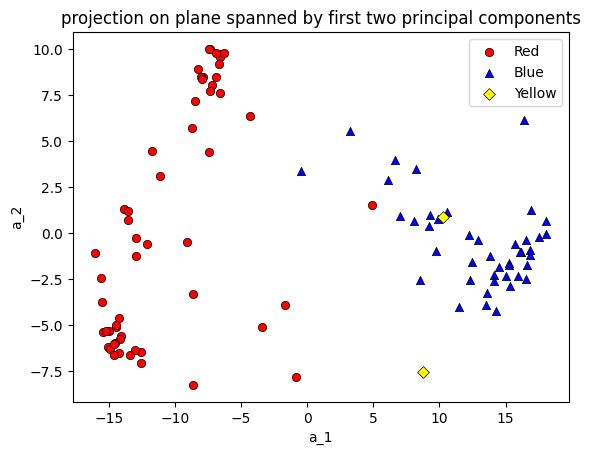

In [ ]:
# calculate projected data matrix and observe its shape
pca = PCA(n_components=2)
projected = pca.fit_transform(X)
print(projected.shape)

# plot projected data matrix
for aff, marker, _ in markers:
    plt.scatter(
        projected[np.array(affiliations) == aff, 0],
        projected[np.array(affiliations) == aff, 1],
        c=aff, marker=marker, edgecolors="black", linewidth=0.5, label=aff
    )
plt.legend()
plt.xlabel('a_1')
plt.ylabel('a_2')
plt.title('projection on plane spanned by first two principal components')
plt.show()

## d) Finding bills that are the most/least contentious

We now wish to observe which bills are the most and least contentious — i.e., those for which most senators voted unanimously, and those for which support was most varied. We consider one possible way of quantifying this relationship mathematically.

We can compute the variance of each column of $X$ — each of which corresponds to a particular bill — and use this variance as a measure of "contentiousness" (i.e., the more contentious a bill, the higher its variance in terms of senator vote count). Note that the variance of a particular bill in column $j$ can be viewed as the variance of scores along $\vec{e}_j$, where $\vec{e}_j$ is a basis vector whose $j^\textrm{th}$ entry is 1 and all others 0.

#### Fill in the code below to calculate the variance of $X$, extract the most and least contentious bills, and plot their vote counts, commenting on your results where indicated.

In [ ]:
# calculate the variance of each column
list_variances = X.var(axis=0)
bills = senator_df['bill_type bill_name bill_ID'].values

################################################################################
### TODO: Compute sorted_idx_variances, an np.array of shape (542,) containing
### integer entries that are the indices of variance scores in list_variances in
### decreasing order of variance. For example, if list_variances = [1, 3, 2, 4],
### then sorted_idx_variances = np.array([3,1,2,0]).
# Hint: Use np.argsort().
list_variances = X.var(axis=0)
sorted_idx_variances = np.argsort(-list_variances)
### end TODO
################################################################################

print(sorted_idx_variances.shape)

(542,)


Using this sorted index, we can now plot the vote counts for the top 5 highest and lowest variance bills.

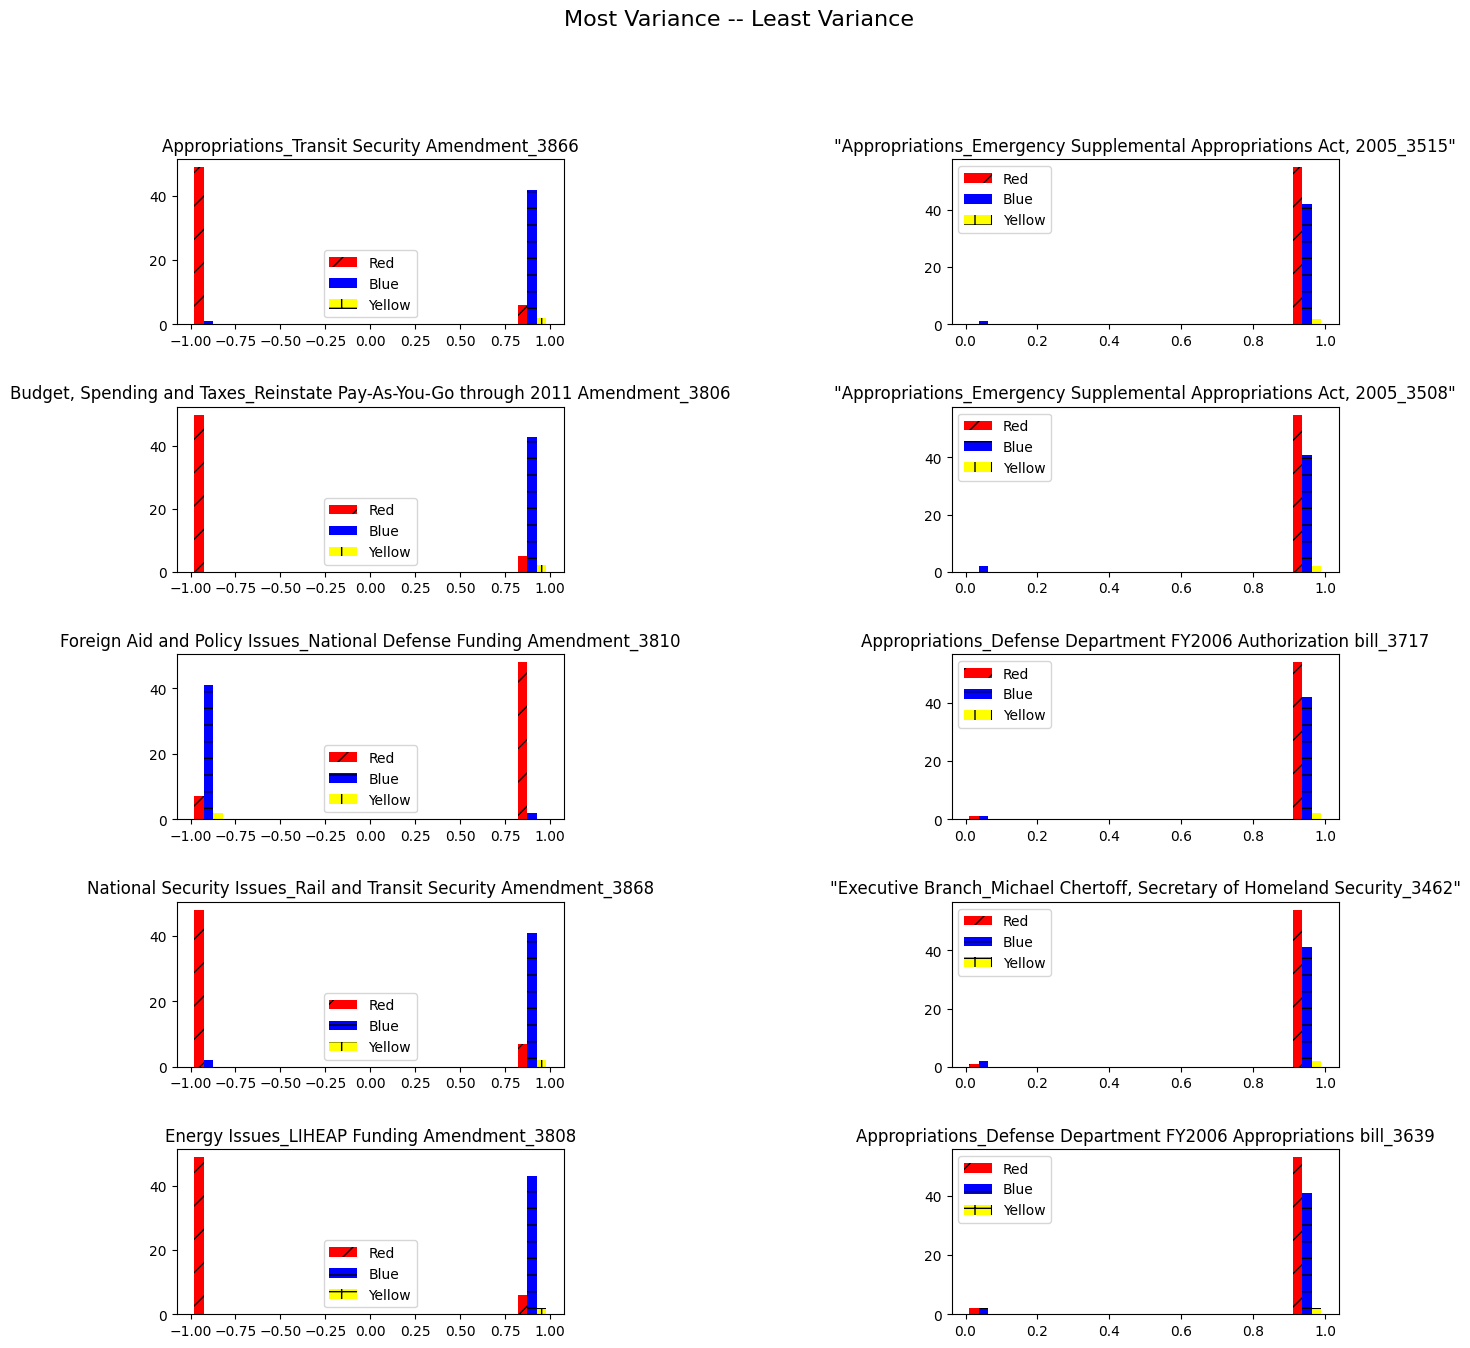

In [ ]:
# retrieve the bills with the 5 highest and lowest variances
top_5 = [bills[sorted_idx_variances[i]] for i in range(5)]
bot_5 = [bills[sorted_idx_variances[-1-i]] for i in range(5)]

# set up figure with all desired subplots
fig, axes = plt.subplots(5,2, figsize=(15,15))

# plot highest variance bills
for i in range(5):
    idx = sorted_idx_variances[i]

    # retrieve vote counts from original uncentered data matrix
    Xs = []
    colors = []
    labels = []
    hatches = []
    for color, _, hatch in markers:
        Xs.append(X_original[np.array(affiliations) == color, idx])
        colors.append(color)
        labels.append(color)
        hatches.append(hatch)

    _, _, patches = axes[i, 0].hist(
        Xs,
        color=colors,
        label=labels,
    )
    for patch_set, hatch in zip(patches, hatches):
        for patch in patch_set.patches:
            patch.set_hatch(hatch)

    axes[i,0].legend()
    axes[i,0].set_title(bills[idx])

# plot lowest variance bills
for i in range(1,6):
    idx2 = sorted_idx_variances[-i]

    # retrieve vote counts from original uncentered data matrix
    Xs = []
    colors = []
    labels = []
    hatches = []
    for color, _, hatch in markers:
        Xs.append(X_original[np.array(affiliations) == color, idx2])
        colors.append(color)
        labels.append(color)
        hatches.append(hatch)

    _, _, patches = axes[i-1, 1].hist(
        Xs,
        color=colors,
        label=labels,
    )
    for patch_set, hatch in zip(patches, hatches):
        for patch in patch_set.patches:
            patch.set_hatch(hatch)

    axes[i-1,1].legend()
    axes[i-1,1].set_title(bills[idx2])

plt.subplots_adjust(hspace=0.5, wspace = 1)
fig.suptitle('Most Variance -- Least Variance', fontsize=16)
plt.show()


### <font color='red'>TODO: Interpretation</font>
#### <font color='red'> Comment on the voting trends you observe in the plots above. In general, if a vote is contentious, what do you expect the plots to look like? What about if a vote is uncontentious?
</font>

#### <font color='blue'> TODO: Fill in the answer.
In the contentious votes, characterized by high variance, you'd expect plots to show a split among senators. Uncontentious votes, on the other hand, display low variance and would have plots with a dominant majority for one option. Essentially, contentious votes result in evenly balanced plots, while uncontentious votes lead to lopsided plots, reflecting consensus.</font>

# e) Infer political affiliation using top two PCA directions
We now consider a strategy to infer the political affiliation of two senators based on how they voted for the bills and considering the projection of their votes onto the two principal components.

In this part, we will compute the top two PCA directions for our given data after removing two specific senators. Then we will plot all the senators in 2D based on their projections on the top two directions as in part c). The two senators whose affiliation needs to be inferred are marked in green and gray. Can you infer the political affiliation (Red or Blue) of the green and gray senator by looking at the points in this 2D plane?

In [ ]:
X_train=np.delete(X,[0,1],0)
affiliations_train=affiliations[:]
affiliations_train[0]='Green'
affiliations_train[1]='Gray'


# this is just used for plotting, feel free to ignore
assert set(affiliations_train) == {"Red", "Blue", "Yellow", "Green", "Gray"}
# assign a marker and hatch to each affiliation
markers_train = [("Red", "o", "/"), ("Blue", "^", "-"), ("Yellow", "D", "+"), ("Green", "s", "x"), ("Gray", "*", ".")]

In [ ]:
# calculate projected data matrix and observe its shape
pca = PCA(n_components=2)
pca.fit(X_train)
projected = pca.transform(X)
print(projected.shape)

(100, 2)


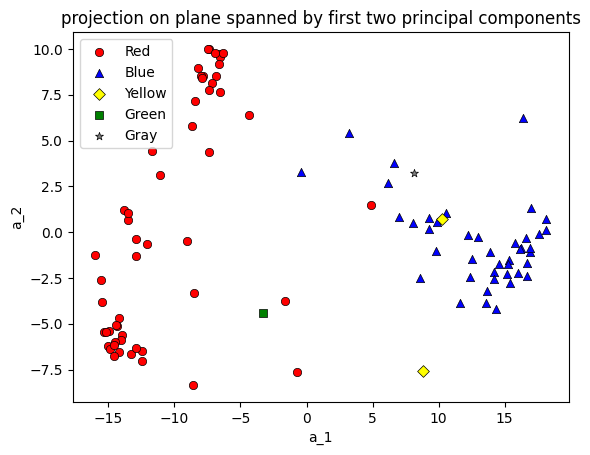

In [ ]:
# plot projected data matrix
for aff, marker, _ in markers_train:
    plt.scatter(
        projected[np.array(affiliations_train) == aff, 0],
        projected[np.array(affiliations_train) == aff, 1],
        c=aff, marker=marker, edgecolors="black", linewidth=0.5, label=aff
    )
plt.legend()
plt.xlabel('a_1')
plt.ylabel('a_2')
plt.title('projection on plane spanned by first two principal components')
plt.show()

### <font color='red'>TODO: Interpretation</font>
#### <font color='red'> Based on the plot above, what is the likely affiliation of the Green senator? What is the likely affiliation of the Grey senator?
</font>

#### <font color='blue'> TODO: Fill in the answer.
The green senator appears closer to the red senators, who sit on the left edge, suggesting the green senator has some voting tendencies with the red group but might not align as strongly as others. On the other hand, the grey point is closer to the blue group, indicating the Grey senator likely shares some views with the blue group.
</font>

## f) Finding extreme senators

Lastly, let us return to our initial definition of $f(X,\vec{a})$, which assigns each senator a score. We will now use this value computed along the first principal component $\vec{a}$ to assign the following classifications to our senators:

- Senators with the top 10 most positive scores and top 10 most negative scores are classified as *most extreme*.
- Senators with the 20 scores closest to 0 are classified as *least extreme*.

In the final subproblem, we observe these scores and how they relate to party affiliation.

We first compute the most extreme senators:

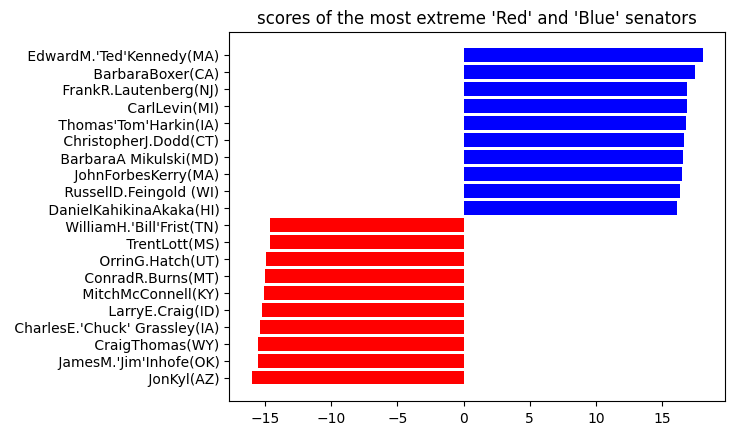

In [ ]:
# extract senator names
senators = senator_df.columns.values[3:]

# compute and sort senators scores and corresponding affiliations
senator_scores = f(X,a_1)
complete_sort_indices = np.argsort(senator_scores)
sort_indices = np.hstack([complete_sort_indices[:10], complete_sort_indices[-11:-1]])
senators_sorted = senators[sort_indices]
senator_scores_sorted = senator_scores[sort_indices]
affiliations = np.array(affiliations)
affiliations_sorted = affiliations[sort_indices]

plt.barh(y = senators_sorted, width = senator_scores_sorted, color = affiliations_sorted)
plt.title('scores of the most extreme \'Red\' and \'Blue\' senators')
plt.show()


And the least extreme senators:

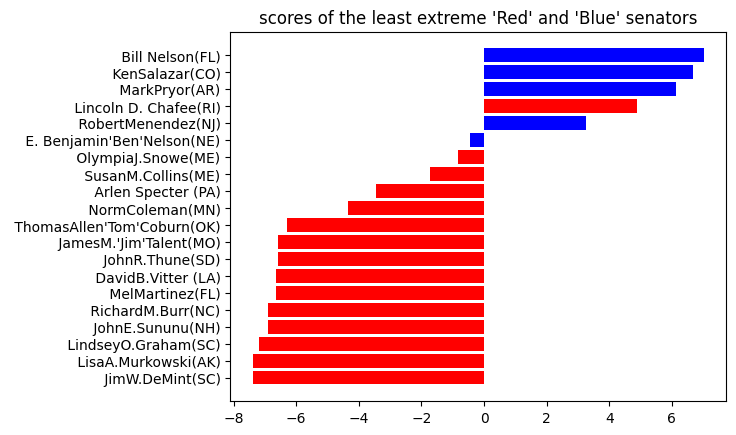

In [ ]:
# compute and sort senators scores and corresponding affiliations
senator_scores = f(X,a_1)
complete_sort_indices = np.argsort(np.abs(senator_scores))[:20]
senator_scores_le= senator_scores[complete_sort_indices]
senators_le = senators[complete_sort_indices]
affiliations = np.array(affiliations)
affiliations_le = affiliations[complete_sort_indices]
sort_indices = np.argsort(senator_scores_le)
senators_sorted = senators_le[sort_indices]
senator_scores_sorted = senator_scores_le[sort_indices]
affiliations_sorted = affiliations_le[sort_indices]

plt.barh(y = senators_sorted, width = senator_scores_sorted, color = affiliations_sorted)
plt.title('scores of the least extreme \'Red\' and \'Blue\' senators')
plt.show()

### <font color='red'>TODO: Interpretation</font>
#### <font color='red'> Comment on the sign of senators' scores and what they say about party affiliation for both the most and least extreme senators.
</font>

#### <font color='blue'> TODO: Fill in the answer.

For most extreme senators, the ten senators with the highest positive scores are all from the blue party, reflecting that their voting behavior strongly correlates with the primary trend of the blue group. Similarly, the ten senators with the most significant negative scores on the red side demonstrate a strong alignment with the main tendencies of the red group.</font>
#### <font color='blue'>
For the least extreme senators, senators whose scores are close to zero exhibit voting patterns that are comparatively moderate, indicating a less polarized stance.
</font>